Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 139MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 12.3MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 82.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.48MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/10], Loss: 0.3515, Accuracy: 89.31%
Epoch [2/10], Loss: 0.1680, Accuracy: 94.86%
Epoch [3/10], Loss: 0.1345, Accuracy: 95.91%
Epoch [4/10], Loss: 0.1203, Accuracy: 96.29%
Epoch [5/10], Loss: 0.1084, Accuracy: 96.66%
Epoch [6/10], Loss: 0.1051, Accuracy: 96.78%
Epoch [7/10], Loss: 0.0953, Accuracy: 97.08%
Epoch [8/10], Loss: 0.0958, Accuracy: 97.07%
Epoch [9/10], Loss: 0.0908, Accuracy: 97.21%
Epoch [10/10], Loss: 0.0860, Accuracy: 97.36%
Test Loss: 0.1431
Test Accuracy: 96.48%


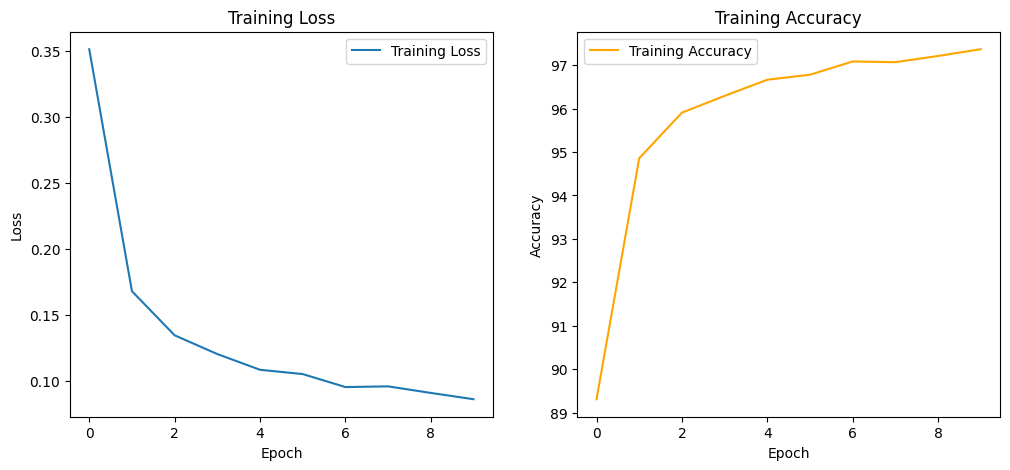

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Best hyperparameters found by Bayesian Optimization
best_params = {
    'learning_rate': 0.0049377927514949885,
    'hidden_size': 256,
    'batch_size': 132
}

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Initialize model, loss, and optimizer
input_size = 28 * 28  # MNIST images are 28x28
num_classes = 10       # 10 digits
model = SimpleNN(input_size, best_params['hidden_size'], num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Train the model
num_epochs = 10  # Number of epochs for training
train_loss_history = []
train_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Flatten the images
        images = images.reshape(-1, input_size)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Store history for plotting
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Evaluate the model on the test set
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()